In [117]:
import pandas as pd
import numpy as np
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from math import floor, ceil, log
from typing import Optional, Literal
from dataclasses import dataclass
import matplotlib.pyplot as plt

In [156]:
class MVA(nn.Module):
    def __init__(self, q: int):
        super().__init__()
        self.q = q
        self.mva = nn.AvgPool1d(kernel_size=q, stride=1)

    def forward(self, x: Tensor) -> Tensor:
        left_pad = x[:, 0:1].repeat(1, floor((self.q - 1) / 2), 1)
        right_pad = x[:, -1:].repeat(1, ceil((self.q - 1) / 2), 1)
        x_padded = torch.cat((left_pad, x, right_pad), dim=1)
        x_trend = self.mva(x_padded.transpose(-2, -1)).transpose(-2, -1)
        return x_trend

class SeriesDecomp(nn.Module):
    def __init__(self, q: int):
        super().__init__()
        self.mva = MVA(q)
    
    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        trend = self.mva(x)
        seasonal = x - trend
        return seasonal, trend

class LayerNorm(nn.Module):
    '''
    Specially designed LayerNorm for the seasonal part.
    '''
    def __init__(self, C_out: int):
        super().__init__()
        self.layer_norm = nn.LayerNorm(C_out)
    
    def forward(
        self, 
        x: Tensor,
    ) -> Tensor:
        x_hat = self.layer_norm(x)
        bias = torch.mean(x_hat, dim=1).unsqueeze(1).repeat(1, x.shape[1], 1)
        return x_hat - bias

In [176]:
df_raw = pd.read_csv('data/AusAntidiabeticDrug.csv')

In [220]:
df = df_raw.copy()
df.loc[:, 'date'] = pd.to_datetime(df['ds'])
dt = df['date'].dt
df.loc[:, 'month'] = dt.month
df.loc[:, 'day'] = dt.day
df.loc[:, 'weekday'] = dt.weekday
df.loc[:, 'hour'] = dt.hour
df.drop(columns=['ds', 'date'], inplace=True)
df.head()

,y,month,day,weekday,hour
0,3.526591,7,1,0,0
1,3.180891,8,1,3,0
2,3.252221,9,1,6,0
3,3.611003,10,1,1,0
4,3.565869,11,1,4,0


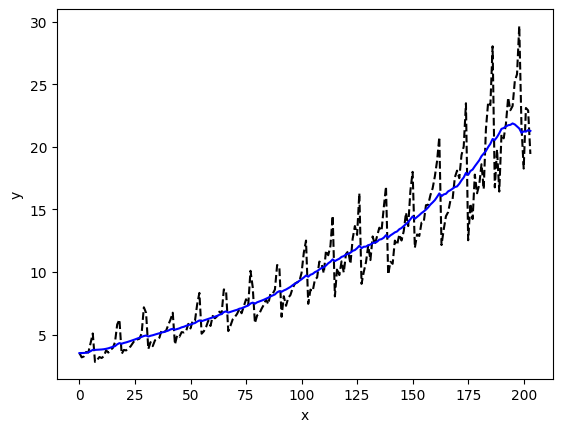

In [230]:
PERIODS = ['month', 'day', 'weekday', 'hour', 'minute']
period2ix = {p: i for i, p in enumerate(PERIODS)}

x = torch.as_tensor(
    df['y'].values.astype(np.float32)
).view(1, -1, 1)
x_mark = torch.as_tensor(
    df[[p for p in PERIODS if p in df.columns]].values
).unsqueeze(0)

decomp = SeriesDecomp(25)
seasonal, trend = decomp(x)

plt.ylabel('y')
plt.xlabel('x')
plt.plot(torch.arange(x.shape[1]), x[0], 'k--', label='y')
plt.plot(torch.arange(x.shape[1]), trend[0], 'b-', label='y')
plt.show()

In [243]:
class TokenEmbedding(nn.Module):
    def __init__(self, C_in: int, D_model: int):
        super().__init__()

        self.token_conv = nn.Conv1d(
            C_in, D_model, kernel_size=3, padding=1, 
            padding_mode='circular', bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(
        self,
        x: Tensor   # (B, L, C)
    ) -> Tensor:    # (B, L, D)
        x = self.token_conv(x.transpose(-2, -1)).transpose(-2, -1)

        return x

class PositionalEmbedding(nn.Module):
    def __init__(self, D_model: int, L_max: int):
        super().__init__()
        
        pe = torch.zeros(L_max, D_model)
        pe.requires_grad = False

        position = torch.arange(0, L_max).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D_model, 2) * -(log(10000.) / D_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # Buffers are tensors which do not require gradients
        # and are thus not registered as parameters.
        # They can be loaded inside the state_dict.
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor):
        return self.pe[:, :x.shape[1]]

Frequency = Literal['t', 'h']

class TemporalEmbedding(nn.Module):
    def __init__(self, D_model: int, max_freq: Frequency):
        super().__init__()
        
        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13
        
        if max_freq == 't':
            self.minute_embd = nn.Embedding(minute_size, D_model)
        self.hour_embd = nn.Embedding(hour_size, D_model)
        self.weekday_embd = nn.Embedding(weekday_size, D_model)
        self.day_embd = nn.Embedding(day_size, D_model)
        self.month_embd = nn.Embedding(month_size, D_model)
    
    def forward(
        self, 
        x_mark: Tensor # ?
    ):
        minute_x = self.minute_embd(x_mark[..., period2ix['minute']]) if hasattr(self, 'minute_embd') else 0.
        hour_x = self.hour_embd(x_mark[..., period2ix['hour']])
        weekday_x = self.weekday_embd(x_mark[..., period2ix['weekday']])
        day_x = self.day_embd(x_mark[..., period2ix['day']])
        month_x = self.month_embd(x_mark[..., period2ix['month']])
        
        return minute_x + hour_x + weekday_x + day_x + month_x
        
class DataEmbedding(nn.Module):
    def __init__(
        self, 
        C_in: int, 
        D_model: int, 
        L_max: int,
        embed_positions: bool = True,
        highest_freq: Frequency = 'h',
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.token_embd = TokenEmbedding(C_in, D_model)
        self.pos_embd = PositionalEmbedding(D_model, L_max)
        self.temp_embd = TemporalEmbedding(D_model, highest_freq)
        self.dropout = nn.Dropout(dropout)
        
        self.embed_positions = embed_positions
    
    def forward(self, x: Tensor, x_mark: Tensor):
        x = self.token_embd(x) + self.temp_embd(x_mark)
        if self.embed_positions:
            x += self.pos_embd(x)
        return self.dropout(x)

In [245]:
tok_embd = TokenEmbedding(1, 64)
pos_embd = PositionalEmbedding(64, 256)
temp_embd = TemporalEmbedding(64, 'h')
data_embd = DataEmbedding(1, 64, 256, embed_positions=True, highest_freq='h')

x_tok = tok_embd(x)
x_pos = pos_embd(x)
x_temp = temp_embd(x_mark)
x_data = data_embd(x, x_mark)

print(x_tok.shape)
print(x_tok.squeeze())
print(x_pos.shape)
print(x_pos.squeeze())
print(x_temp.shape)
print(x_temp.squeeze())
print(x_data.shape)
print(x_data.squeeze())

torch.Size([1, 204, 64])
tensor([[ 1.2771e+01, -2.1767e+00, -8.5968e-01,  ..., -1.9461e+01,
         -4.4283e-02, -2.2962e+01],
        [ 8.8997e+00,  9.2539e-02,  5.2203e+00,  ..., -2.5464e+00,
         -3.4510e-01, -6.2409e+00],
        [ 9.4230e+00,  2.0511e-01,  5.8965e+00,  ..., -1.7565e+00,
         -4.9695e-01, -6.0556e+00],
        ...,
        [ 6.1932e+01,  1.5917e+00,  3.9814e+01,  ..., -1.1922e+01,
         -2.2176e+00, -3.7357e+01],
        [ 5.7711e+01,  2.9165e-01,  3.3003e+01,  ..., -2.1678e+01,
         -5.4073e-01, -4.0898e+01],
        [ 3.0651e+01, -2.4964e+00,  8.8722e+00,  ..., -4.0311e+01,
          5.9385e+00, -3.2773e+01]], grad_fn=<SqueezeBackward0>)
torch.Size([1, 204, 64])
tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  6.8156e-01,  ...,  1.0000e+00,
          1.3335e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.9748e-01,  ...,  1.0000e+00,
          2.6670e

In [246]:
BATCH_SIZE = 32
SEQ_LEN = 128
EMBED_DIM = 32

B, L, E = BATCH_SIZE, SEQ_LEN, EMBED_DIM

In [249]:
HEAD_SIZE = EMBED_DIM
TOP_K = 3
dH = HEAD_SIZE

query_projection = nn.Linear(E, dH)
key_projection = nn.Linear(E, dH)
value_projection = nn.Linear(E, dH)

torch.manual_seed(42)
x = torch.randn(B, L, E)
queries = query_projection(x) # (B, L, H)
keys = key_projection(x) # (B, L, H)
values = value_projection(x) # (B, L, H)

def autocorrelation_paper():
    q_fft = torch.fft.rfft(queries.transpose(-2, -1).contiguous(), dim=-1)
    k_fft = torch.fft.rfft(keys.transpose(-2, -1).contiguous(), dim=-1)
    s = q_fft * k_fft.conj()
    corr = torch.fft.irfft(s, n=L, dim=-1) # (B, H, L)
    weights, delays = torch.topk(corr, TOP_K, dim=-1) # (B, H, k)
    weights = torch.softmax(weights, dim=-1)
    init_index = torch.arange(L).view(1, 1, L).repeat(B, dH, 1)
    tmp_values = values.transpose(-2, -1).repeat(1, 1, 2) # (B, H, 2L)
    delays_agg = torch.zeros_like(values.transpose(-2, -1))
    for i in range(TOP_K):
        tmp_delay = init_index + delays[..., i].unsqueeze(-1)
        pattern = torch.gather(tmp_values, dim=-1, index=tmp_delay)
        delays_agg += pattern * weights[..., i].unsqueeze(-1)
    return delays_agg # (B, H, L)

def autocorrelation_custom():
    q_fft = torch.fft.rfft(queries, dim=1)
    k_fft = torch.fft.rfft(keys, dim=1)
    tmp_corr = q_fft * k_fft.conj()
    corr = torch.fft.irfft(tmp_corr, n=L, dim=1)
    weights, delays = torch.topk(corr, TOP_K, dim=1) # (B, k, H)
    weights = torch.softmax(weights, dim=1)
    init_index = torch.arange(L).view(1, L, 1).repeat(B, 1, dH)
    # Repeat twice so that elements shifted beyond the 1st position reappear at the end
    tmp_values = values.repeat(1, 2, 1) # (B, 2L, H)
    delays_agg = torch.zeros_like(values)
    for i in range(TOP_K):
        tmp_delay = init_index + delays[:, i].view(B, 1, dH)
        pattern = torch.gather(tmp_values, dim=1, index=tmp_delay)
        delays_agg += pattern * weights[:, i].view(B, 1, dH)
    return delays_agg # (B, L, H)

(autocorrelation_paper().transpose(-2, -1)).allclose(autocorrelation_custom(), atol=1e-7)
# autocorrelation_custom().shape

True

In [39]:
class AutoCorrelation(nn.Module):
    '''
    Multihead attention module with autocorrelation.
    '''
    
    def __init__(self, c: float):
        '''
        :param c: Constant used to determine the number of top-k sub-series to use.
        '''
        super().__init__()
        self.c = c
    
    def forward(
        self,
        queries: Tensor, # (B, L, nH, dH)
        keys: Tensor, # (B, L, nH, dH),
        values: Tensor, # (B, L, nH, dH)
    ) -> tuple[Tensor, Tensor]: # ?
        q, k, v = queries, keys, values

        B, L, nH, dH = q.shape
        _, S, _ , _ = keys.shape

        assert B  == k.shape[0] == v.shape[0]
        assert S  == v.shape[1]
        assert nH == k.shape[2] == v.shape[2]
        assert dH == k.shape[3]

        # Make q, k, v the same length L
        if S < L:
            zeros = torch.zeros((B, L-S, nH, dH))
            k = torch.cat([k, zeros], dim=1)
            v = torch.cat([v, zeros], dim=1)
        else:
            k = k[:, :L]
            v = v[:, :L]
        
        q_fft = torch.fft.rfft(q, dim=1)
        k_fft = torch.fft.rfft(k, dim=1)
        tmp_corr = q_fft * k_fft.conj()
        corr = torch.fft.irfft(tmp_corr, n=L, dim=1)

        top_k = floor(self.c * log(L))
        
        weights, delays = torch.topk(corr, top_k, dim=1) # (B, k, nH, dH), (B, k, nH, dH)
        weights = torch.softmax(weights, dim=1)

        # repeat the values twice so that elements shifted beyond the 1st position reappear at the end
        tmp_values = values.repeat(1, 2, 1, 1) # (B, 2L, nH, dH)
        init_index = torch.arange(L).view(1, L, 1, 1).repeat(B, 1, nH, dH)
        v_new = torch.zeros_like(values)

        for i in range(top_k):
            tmp_delay = init_index + delays[:, i].unsqueeze(1)
            pattern = torch.gather(tmp_values, dim=1, index=tmp_delay)
            v_new += pattern * weights[:, i].view(B, 1, nH, dH)
        
        return v_new, corr

In [250]:
N_HEADS = 1

dQK  = E // N_HEADS
dV = E // N_HEADS

q_mva = query_projection(x).view(B, L, N_HEADS, dQK)
k = key_projection(x).view(B, L, N_HEADS, dQK)
v = value_projection(x).view(B, L, N_HEADS, dV)

c = 3.5 / log(L)
ac = AutoCorrelation(c)
v2, _ = ac(q_mva, k, v)
torch.allclose(v2.squeeze(), autocorrelation_custom())

True

In [41]:
class AutoCorrelationLayer(nn.Module):
    def __init__(self, attention: nn.Module, D: int, nH: int):
        '''
        :param D: Dimension of the input and output vectors.
        :param nH: Number of heads.
        :param c: Constant used in AutoCorrelation.
        '''
        super().__init__()

        dQK = D // nH
        dV  = D // nH
        
        self.query_projection = nn.Linear(D, dQK * nH)
        self.key_projection = nn.Linear(D, dQK * nH)
        self.value_projection = nn.Linear(D, dV * nH)
        self.out_projection = nn.Linear(dV * nH, D)
        
        self.attention = attention

        self.nH = nH

    def forward(
        self,
        queries: Tensor, # (B, L, D)
        keys: Tensor, # (B, S, D)
        values: Tensor, # (B, L, D)
        # attn_mask: Tensor
    ) -> Tensor:
        B, L, D = queries.shape
        _, S, _ = keys.shape
        nH = self.nH
        
        assert B == keys.shape[0] == values.shape[0]
        assert S == values.shape[1]
        assert D == keys.shape[2] == values.shape[2]
        
        queries = self.query_projection(queries).view(B, L, nH, -1)
        keys = self.key_projection(keys).view(B, S, nH, -1)
        values = self.value_projection(values).view(B, S, nH, -1)

        out, attn = self.attention(queries, keys, values).view(B, L, -1)
        out = self.out_projection(out)

        return out, attn

In [42]:
Activation = Literal['relu', 'gelu']

class EncoderLayer(nn.Module):
    def __init__(
        self, 
        attention: nn.Module,
        D_model: int,
        D_ff: Optional[int] = None,
        q_mva: Optional[int] = 25,
        dropout: Optional[float] = 0.2,
        activation: Optional[Activation] = 'relu'
    ):
        '''
        :param D: Dimension of the input and output vectors.
        :param attention: Attention module to use, needs to accept queries, keys, values with shape (B, L, D).
        :param D_ff: 
        :param q: 
        :param dropout: 
        '''
        super().__init__()

        D_ff = D_ff or D_model * 4

        self.dropout = nn.Dropout(dropout)
        self.decomp1 = SeriesDecomp(q_mva)
        self.conv1 = nn.Conv1d(D_model, D_ff, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(D_ff, D_model, kernel_size=1, bias=False)
        self.activation = F.relu if activation == 'relu' else F.gelu
        
        self.attention = attention

    def forward(
        self,
        x: Tensor, # (B, L, D)
        attn_mask: Optional[Tensor] = None # ?
    ) -> tuple[Tensor, Tensor]: # (B, L, D), ?
        x, attn = (
            self.attention(
                x, x, x,
                attn_mask=attn_mask
            )
        )
        x = x + self.dropout(x)
        x, _ = self.decomp1(x)
        y = self.dropout(
            self.activation(
                self.conv1(
                    x.transpose(-2, -1)
                )
            )
        )
        y = self.dropout(
            self.conv2(y)
            .transpose(-2, -1)
        )
        x, _ = self.decomp2(x + y)
        return x, attn

In [43]:
class Encoder(nn.Module):
    def __init__(
        self,
        attn_layers: list[nn.Module],
        conv_layers: Optional[list[nn.Module]] = None,
        norm_layer: Optional[nn.Module] = None,
    ):
        super().__init__()
        
        if conv_layers is not None:
            assert len(conv_layers) < len(attn_layers)
        
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm_layer = norm_layer
    
    def forward(
        self,
        x: Tensor, # (B, L, D)
        attn_mask: Optional[Tensor] = None # ?
    ) -> Tensor:
        attns = []
        if self.conv_layers is not None:
            # ? test
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)
        if self.norm_layer is not None:
            x = self.norm_layer(x)
        return x, attns

In [50]:
@dataclass
class AutoformerConfig:
    D_model: int
    D_ff: int
    c_autocorrelation: float
    n_heads: int
    q_mva: int
    dropout: float
    activation: Activation
    encoder_layers: int

class Autoformer(nn.Module):
    def __init__(self, config: AutoformerConfig):
        super().__init__()
        
        self.encoder = Encoder(
            attn_layers=[
                EncoderLayer(
                    AutoCorrelationLayer(
                        AutoCorrelation(config.c_autocorrelation),
                        config.D_model,
                        config.n_heads
                    ),
                    config.D_model,
                    config.D_ff,
                    config.q_mva,
                    config.dropout,
                    config.activation
                ) for _ in range(config.encoder_layers)
            ],
            norm_layer=LayerNorm(config.D_model)
        )